#Mounting Drive and Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#Upsampling via Geometric Transformation and GAN

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IndustrialOcr.zip", 'r')
zip_ref.extractall("/content/")
zip_ref.close()

In [ ]:
unzipped_folder = "/content/IndustrialOcr"

for root, dirs, files in os.walk(unzipped_folder):
    #print(f"Folder: {root}")
    if dirs:
        print(f"Subfolders: {dirs}")

Subfolders: ['Test', 'Train']
Subfolders: ['23305982', '23301608', 'D0CW-51310', 'D0CW-51301', '52611-0E110-A', '23354374', 'BK21-64842-A-B', '20871905', '70085119-0300', '23477043', 'D0CW-51300', '23497667']
Subfolders: ['23305982', '23301608', 'D0CW-51310', 'D0CW-51301', '52611-0E110-A', '23354374', 'BK21-64842-A-B', '20871905', '70085119-0300', '23477043', 'D0CW-51300', '23497667']


In [ ]:
# Load minority class images
def load_images(directory, img_size=(128, 128)):
    images = []
    for img_file in os.listdir(directory):
        if img_file.endswith('.jpg') or img_file.endswith('.png'):
            img_path = os.path.join(directory, img_file)
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
    return np.array(images)

In [ ]:
#Generator
def build_generator(latent_dim):
    model = Sequential([
        #Input Layer
        Dense(8 * 8 * 256, input_dim=latent_dim),
        LeakyReLU(alpha=0.2),
        Reshape((8, 8, 256)),

        # Upsample to 16x16
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        # Upsample to 32x32
        Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        # Upsample to 64x64
        Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        #Upsampling  to  128x128
        Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        # Output layer
        Conv2DTranspose(3, kernel_size=4, strides=1, activation='tanh', padding='same') #3 => RGB #tanh keep value [-1,1]
    ])

    return model

In [ ]:
#Discriminator
def build_discriminator(input_shape=(128, 128, 3)):
    model = Sequential([
        Conv2D(64, kernel_size=4, strides=2, input_shape=input_shape, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        Conv2D(128, kernel_size=4, strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),

        Flatten(),
        Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
#Compile GAN
def build_gan(generator, discriminator, lr=0.0002):
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
    discriminator.trainable = False
    gan_input = tf.keras.Input(shape=(latent_dim,))
    img = generator(gan_input)
    gan_output = discriminator(img)
    gan = tf.keras.Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=Adam(lr))
    return gan

In [ ]:
#Training Function
def train_gan(generator, discriminator, gan, data, latent_dim, epochs=1000, batch_size=32):
    half_batch = batch_size // 2 #balance real and fake

    for epoch in range(epochs):
        idx = np.random.randint(0, data.shape[0], half_batch)
        real_imgs = data[idx]
        #generate fake image
        fake_imgs = generator.predict(np.random.normal(0, 1, (half_batch, latent_dim))) #input noise vector

        real_labels = np.ones((half_batch, 1)) #real=1
        fake_labels = np.zeros((half_batch, 1)) #fake=0

        d_loss_real = discriminator.train_on_batch(real_imgs, real_labels) #built-in keras function
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels) #built-in keras function
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) #error to detect fake image

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1)) #making label real -> generator believe it's creating a real image
        g_loss = gan.train_on_batch(noise, valid_y) #discrimanot can detect fake image

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: D Loss = {d_loss[0]}, G Loss = {g_loss}")

In [ ]:
#Path
train_dirs = {
    #Add 80
    "class_1": "/content/IndustrialOcr/Train/20871905",
    #Add 70
    "class_3": "/content/IndustrialOcr/Train/70085119-0300",
}

latent_dim = 100 #noise vector size

In [ ]:
# Load minority class images
train_data = {label: load_images(path) for label, path in train_dirs.items()}

In [ ]:
# Initialize models
generators = {label: build_generator(latent_dim) for label in train_dirs}
discriminators = {label: build_discriminator() for label in train_dirs}
gans = {label: build_gan(generators[label], discriminators[label]) for label in train_dirs}

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
'''
# Train GAN for each class
for label in train_dirs:
    print(f"Training on {label} (Train)")
    train_gan(generators[label], discriminators[label], gans[label], train_data[label], latent_dim)
'''

'\n# Train GAN for each class\nfor label in train_dirs:\n    print(f"Training on {label} (Train)")\n    train_gan(generators[label], discriminators[label], gans[label], train_data[label], latent_dim)\n'

In [ ]:
print("Training on class_1 (Train)")
train_gan(generators["class_1"], discriminators["class_1"], gans["class_1"], train_data["class_1"], latent_dim)

Training on class_1 (Train)
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0: D Loss = 0.637946605682373, G Loss = 0.6931309700012207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

In [ ]:
print("Training on class_3 (Train)")
train_gan(generators["class_3"], discriminators["class_3"], gans["class_3"], train_data["class_3"], latent_dim)

Training on class_3 (Train)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 545ms/step
Epoch 0: D Loss = 0.628320574760437, G Loss = 0.6925967335700989
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms

In [ ]:
# Generate synthetic images
def generate_images(generator, num_images, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    noise = np.random.normal(0, 1, (num_images, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = (gen_imgs * 127.5 + 127.5).astype(np.uint8)  # Rescale to [0,255]

    for i, img in enumerate(gen_imgs):
        tf.keras.preprocessing.image.save_img(f"{save_dir}/synthetic_{i}.png", img)

In [ ]:
#Number of image
image_counts = {
    "class_1": 80,
    "class_3": 70,
}

# Generate images
for label, path in train_dirs.items():
    num_images = image_counts[label]  #Images Per Class
    print(f"Generating {num_images} synthetic images for {label} (Train)")
    generate_images(generators[label], num_images, path)

print("Synthetic images saved!")

In [ ]:
# Define the paths for six minority class directories

#Upsample x20
minority_test_class_dir_1 = "/content/IndustrialOcr/Test/20871905"
minority_test_class_dir_2 = "/content/IndustrialOcr/Test/BK21-64842-A-B"

#Upsample x10
minority_test_class_dir_3 = "/content/IndustrialOcr/Test/70085119-0300"
minority_test_class_dir_4 = "/content/IndustrialOcr/Test/D0CW-51300"
minority_test_class_dir_5 = "/content/IndustrialOcr/Test/D0CW-51301"
minority_test_class_dir_6 = "/content/IndustrialOcr/Test/D0CW-51310"

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Function to augment images and save it
def augment_images_in_directory_first(directory, prefix="aug_"): #aug in name
    image_files = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]

    for i, image_file in enumerate(image_files):
        # Load
        img_path = os.path.join(directory, image_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)  #Dimensions to (1, h, w, c)

        # Generate and save
        j = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=directory, save_prefix=prefix, save_format='jpeg'):
            j += 1
            if j >= 20:  # 1 original => 20 augmented
                break  # Stop

In [ ]:
augment_images_in_directory_first(minority_test_class_dir_1, prefix="aug_1_")
augment_images_in_directory_first(minority_test_class_dir_2, prefix="aug_2_")

In [ ]:
# Function to augment images and save it
def augment_images_in_directory_second(directory, prefix="aug_"): #aug in name
    image_files = [f for f in os.listdir(directory) if f.endswith('.jpg') or f.endswith('.png')]

    for i, image_file in enumerate(image_files):
        # Load
        img_path = os.path.join(directory, image_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)  #Dimensions to (1, h, w, c)

        # Generate and save
        j = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=directory, save_prefix=prefix, save_format='jpeg'):
            j += 1
            if j >= 10:  # 1 original => 10 augmented
                break  # Stop

In [ ]:
augment_images_in_directory_second(minority_test_class_dir_3, prefix="aug_3_")
augment_images_in_directory_second(minority_test_class_dir_4, prefix="aug_4_")
augment_images_in_directory_second(minority_test_class_dir_5, prefix="aug_5_")
augment_images_in_directory_second(minority_test_class_dir_6, prefix="aug_6_")

In [ ]:
# Define paths
base_folder = "/content/BalancedviaUpsampled"
train_folder = os.path.join(base_folder, "Train")
test_folder = os.path.join(base_folder, "Test")
zip_path = "/content/IndustrialOcrGAN.zip"  # Zip file path
drive_path = "/content/drive/MyDrive/IndustrialOcrGAN.zip"  # Destination in Google Drive

# Ensure the base folder exists
os.makedirs(base_folder, exist_ok=True)

# Move Train and Test into BalancedviaUpsampled
shutil.move("/content/IndustrialOcr/Train", train_folder)
shutil.move("/content/IndustrialOcr/Test", test_folder)

# Create a zip file
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', base_folder)

# Move the zip file to Google Drive
shutil.move(zip_path, drive_path)

print("Zipping and upload to Google Drive completed successfully!")

Zipping and upload to Google Drive completed successfully!


#Model Training and Evaluation

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IndustrialOcrGAN.zip", 'r')
os.makedirs("/content/IndustrialOcr", exist_ok=True)
zip_ref.extractall("/content/IndustrialOcr")
zip_ref.close()

In [ ]:
import os

train_folder = "/content/IndustrialOcr/Train"
test_folder = "/content/IndustrialOcr/Test"

for root, dirs, files in os.walk(train_folder):
    #print(f"Folder: {root}")
    if dirs:
        print(f"Train Subfolders: {dirs}")
    '''
    if files:
        print(f"Train Files: {files}")
    print("-" * 40)
    '''
for root, dirs, files in os.walk(test_folder):
    #print(f"Folder: {root}")
    if dirs:
        print(f" Test Subfolders: {dirs}")
    '''
    if files:
        print(f"Test Files: {files}")
    print("-" * 40)
    '''

Train Subfolders: ['BK21-64842-A-B', '23477043', 'D0CW-51301', 'D0CW-51310', '23305982', '23354374', '23301608', '23497667', 'D0CW-51300', '70085119-0300', '52611-0E110-A', '20871905']
 Test Subfolders: ['BK21-64842-A-B', '23477043', 'D0CW-51301', 'D0CW-51310', '23305982', '23354374', '23301608', '23497667', 'D0CW-51300', '70085119-0300', '52611-0E110-A', '20871905']


In [ ]:
# Define paths
train_dir = '/content/IndustrialOcr/Train'
test_dir = '/content/IndustrialOcr/Test'

desired_classes = ['20871905', '23301608', '23305982', '23354374', '23477043', '23497667', '52611-0E110-A', '70085119-0300']
# Update the train and test generators
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    classes=desired_classes  # Only these classes
)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle=False,  #To Reproduce Result
    classes=desired_classes  # Only these classes
)

Found 1621 images belonging to 8 classes.
Found 409 images belonging to 8 classes.


In [ ]:
#Number of images per class
train_class_counts = {class_name: np.sum(train_generator.labels == index) for class_name, index in train_generator.class_indices.items()}
test_class_counts = {class_name: np.sum(test_generator.labels == index) for class_name, index in test_generator.class_indices.items()}

print("Training set class distribution:", train_class_counts)
print("Test set class distribution:", test_class_counts)

Training set class distribution: {'20871905': 87, '23301608': 332, '23305982': 77, '23354374': 256, '23477043': 476, '23497667': 234, '52611-0E110-A': 76, '70085119-0300': 83}
Test set class distribution: {'20871905': 21, '23301608': 84, '23305982': 20, '23354374': 64, '23477043': 120, '23497667': 58, '52611-0E110-A': 20, '70085119-0300': 22}


In [ ]:
# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

#Freeze
base_model.trainable = False

# Add layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

#Build
model = Model(inputs=base_model.input, outputs=predictions)

#Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
'''
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 16,
    epochs=25
)
'''

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 32s 215ms/step - accuracy: 0.8983 - loss: 0.4017
Epoch 2/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step - accuracy: 1.0000 - loss: 0.0092 
Epoch 3/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


101/101 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.9823 - loss: 0.0703
Epoch 4/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 123us/step - accuracy: 1.0000 - loss: 0.0392 
Epoch 5/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 186ms/step - accuracy: 0.9918 - loss: 0.0445
Epoch 6/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - accuracy: 1.0000 - loss: 6.4040e-05 
Epoch 7/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - accuracy: 0.9958 - loss: 0.0321
Epoch 8/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step - accuracy: 1.0000 - loss: 1.4852e-04 
Epoch 9/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 47s 280ms/step - accuracy: 0.9950 - loss: 0.0242
Epoch 10/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 118us/step - accuracy: 1.0000 - loss: 0.0049 
Epoch 11/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 164ms/step - accuracy: 0.9976 - loss: 0.0098
Epoch 12/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - accuracy: 1.0000 - loss: 1.7054e-04 
Epoch 13/25
101/101 ━━━━━━━━━━━━━━━━━━━━ 25s 207ms/step - accuracy: 0.9981 - loss: 0.0093
Epoch 14/25
101/

In [ ]:
#weights_path = '/content/drive/MyDrive/MV Weight/Minority Class Upsampling/mv_minority_GAN.weights.h5'

#model.save_weights(weights_path)
#print(f"Weights saved at: {weights_path}")

model.load_weights('/content/drive/MyDrive/MV Weight/Minority Class Upsampling/mv_minority_GAN.weights.h5',skip_mismatch=True)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# Evaluate Model on Test Data
loss, accuracy = model.evaluate(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step - accuracy: 0.9631 - loss: 0.1869


In [ ]:
print(test_generator.class_indices)

{'20871905': 0, '23301608': 1, '23305982': 2, '23354374': 3, '23477043': 4, '23497667': 5, '52611-0E110-A': 6, '70085119-0300': 7}


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['20871905', '23301608', '23305982', '23354374', '23477043', '23497667', '52611-0E110-A', '70085119-0300']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

26/26 ━━━━━━━━━━━━━━━━━━━━ 13s 396ms/step
Confusion Matrix
[[ 18   3   0   0   0   0   0   0]
 [  0  82   0   0   2   0   0   0]
 [  0   0  20   0   0   0   0   0]
 [  0   0   0  64   0   0   0   0]
 [  0   2   0   0 118   0   0   0]
 [  0   0   0   0   0  58   0   0]
 [  0   0   0   0   0   0  20   0]
 [  0   0   0   0   0   0   1  21]]
Classification Report
               precision    recall  f1-score   support

     20871905       1.00      0.86      0.92        21
     23301608       0.94      0.98      0.96        84
     23305982       1.00      1.00      1.00        20
     23354374       1.00      1.00      1.00        64
     23477043       0.98      0.98      0.98       120
     23497667       1.00      1.00      1.00        58
52611-0E110-A       0.95      1.00      0.98        20
70085119-0300       1.00      0.95      0.98        22

     accuracy                           0.98       409
    macro avg       0.98      0.97      0.98       409
 weighted avg       0.98      0

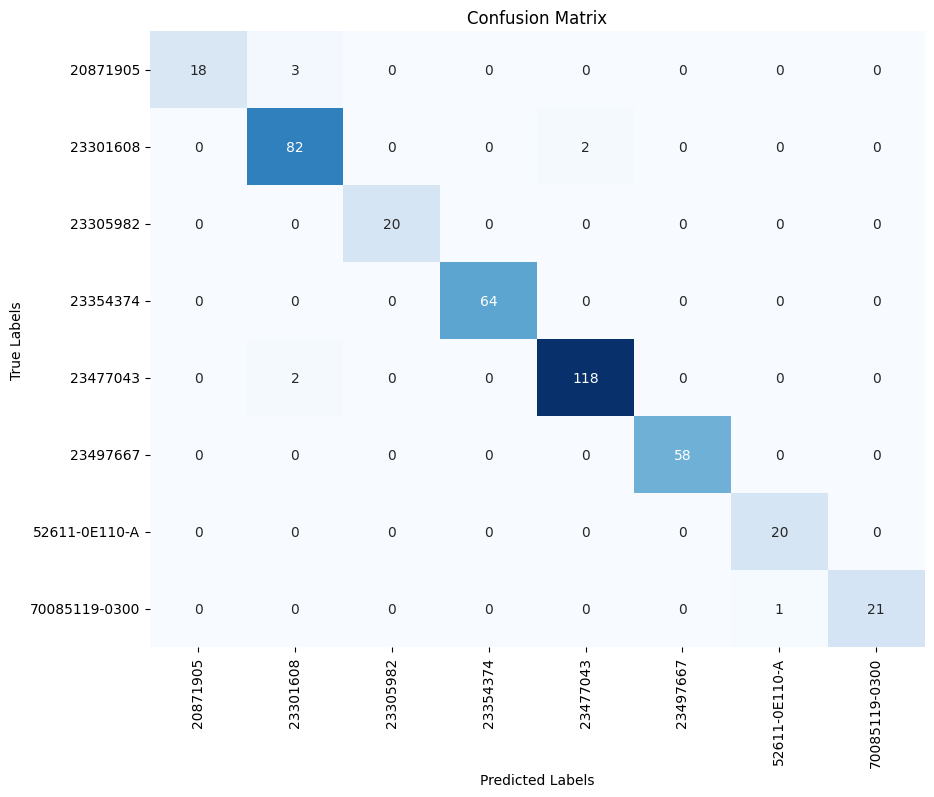

In [ ]:
# Define target class names
target_names = ['20871905', '23301608', '23305982', '23354374', '23477043', '23497667', '52611-0E110-A', '70085119-0300']

# Generate the confusion matrix
confmat = confusion_matrix(test_generator.classes, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confmat, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names, cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#Other Visualization

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


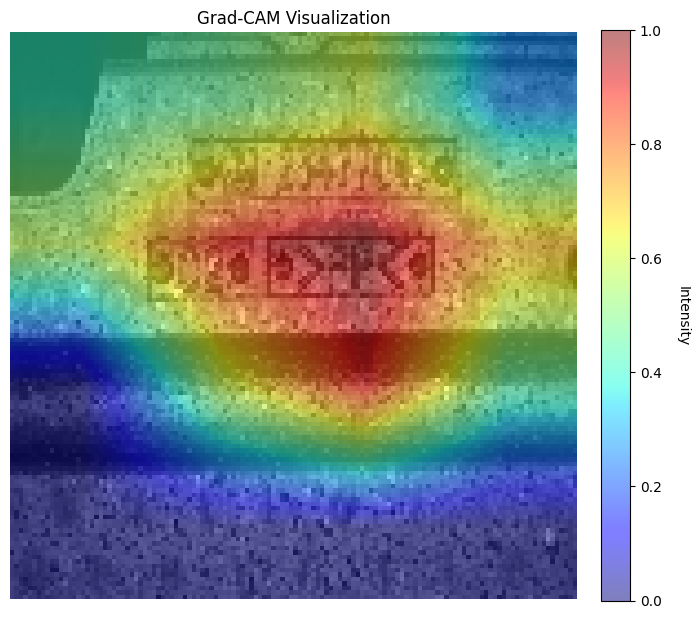

In [ ]:
# Load and preprocess the image
img_path = "/content/Train/23477043/23477043_358.jpg"  # Replace with your image path
image = load_img(img_path, target_size=(128, 128))  # Assuming input size is 224x224
image_array = img_to_array(image)
image_array = np.expand_dims(image_array, axis=0)
image_array = image_array / 255.0  # Normalize if the model was trained on normalized data

# Get the last convolutional layer
last_conv_layer = model.get_layer('Conv_1_bn')  # Replace with the actual layer name

# Create a model that outputs the last conv layer and predictions
grad_model = tf.keras.models.Model(
    [model.inputs],
    [last_conv_layer.output, model.output]
)

# Compute gradients
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(image_array)
    predicted_class = tf.argmax(predictions[0])
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Weight the conv outputs with the gradients
conv_outputs = conv_outputs[0]
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

# Normalize the heatmap
heatmap = np.maximum(heatmap, 0)  # ReLU
heatmap /= np.max(heatmap)

# Resize heatmap to match the image size
heatmap = tf.image.resize(heatmap[..., np.newaxis], (image.size[1], image.size[0]))
heatmap = heatmap.numpy()
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Overlay the heatmap on the image
plt.figure(figsize=(8, 8))

# Show the original image
plt.imshow(image)
# Overlay the heatmap
heatmap_plot = plt.imshow(heatmap[..., 0], cmap='jet', alpha=0.5)  # Alpha controls transparency

# Add a colorbar
cbar = plt.colorbar(heatmap_plot, fraction=0.046, pad=0.04)  # Adjusts the size and position of the colorbar
cbar.set_label('Intensity', rotation=270, labelpad=20)  # Label with rotation and padding

# Finalize the plot
plt.axis('off')
plt.title("Grad-CAM Visualization")
plt.show()